In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

/Users/Moussavi/Desktop/image_segmentation/.venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


In [3]:
!pip install torch torchvision scikit-learn matplotlib pillow pandas numpy

  Using cached torch-2.2.2-cp38-none-macosx_10_9_x86_64.whl.metadata (25 kB)
  Using cached torchvision-0.17.2-cp38-cp38-macosx_10_13_x86_64.whl.metadata (6.6 kB)
  Using cached scikit_learn-1.3.2-cp38-cp38-macosx_10_9_x86_64.whl.metadata (11 kB)
  Using cached matplotlib-3.7.5-cp38-cp38-macosx_10_12_x86_64.whl.metadata (5.7 kB)
  Using cached pillow-10.4.0-cp38-cp38-macosx_10_10_x86_64.whl.metadata (9.2 kB)
  Using cached pandas-2.0.3-cp38-cp38-macosx_10_9_x86_64.whl.metadata (18 kB)
  Using cached numpy-1.24.4-cp38-cp38-macosx_10_9_x86_64.whl.metadata (5.6 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.1-py3-none-any.whl.metadata (5.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached scipy-1.10.1-cp38-cp38-macosx_10_9_x86_64.whl.metadata (53 kB)
  Using cached joblib-1.4.2-py3-no

In [4]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cpu


In [6]:
import os

print(os.listdir("./animal-faces"))

['afhq']


Let's put the dataset into Panda

In [7]:
image_path = [] # Empty array where we will fill the paths of the images
labels = [] # Empty array where we will fill the labes of the images

for i in os.listdir("./animal-faces/afhq/"): # Looping through the first directory which has the train and val images
  for label in os.listdir(f"./animal-faces/afhq/{i}"): # Looping through the first directory which has the labels folders
    for image in os.listdir(f"./animal-faces/afhq/{i}/{label}"): # Looping through all the images of this label
      labels.append(label) # Append/Put this label in the list
      image_path.append(f"./animal-faces/afhq/{i}/{label}/{image}") # Append/Put this image path in the list to read it later

data_df = pd.DataFrame(zip(image_path, labels), columns = ['image_paths', 'labels']) # Create a dataframe contains the images paths and the labels
data_df.head() # Visualizing the first 5 rows

,image_paths,labels
0,./animal-faces/afhq/train/cat/pixabay_cat_0004...,cat
1,./animal-faces/afhq/train/cat/pixabay_cat_0019...,cat
2,./animal-faces/afhq/train/cat/pixabay_cat_0046...,cat
3,./animal-faces/afhq/train/cat/pixabay_cat_0022...,cat
4,./animal-faces/afhq/train/cat/pixabay_cat_0025...,cat


Splitting the Dataset (Training 70%, Validation 15%, Test 15%).
* sample() make a random sample of frac %.
* drop() take the leftover part (100 - frac %)

In [8]:
train=data_df.sample(frac=0.7,random_state=7) # Create training of 70% of the data
test=data_df.drop(train.index) # Create testing by removing the 70% of the train data which will result in 30%

val=test.sample(frac=0.5,random_state=7) # Create validation of 50% of the testing data
test=test.drop(val.index) # Create testing by removing the 50% of the validation data which will result in 50%

In [32]:
print(train.head())  # Shows first few rows
print(train.columns)  # Shows column names

                                             image_paths labels
12388  ./animal-faces/afhq/train/wild/pixabay_wild_00...   wild
6596   ./animal-faces/afhq/train/dog/pixabay_dog_0014...    dog
5367   ./animal-faces/afhq/train/dog/pixabay_dog_0038...    dog
13331  ./animal-faces/afhq/train/wild/flickr_wild_002...   wild
14958  ./animal-faces/afhq/val/cat/pixabay_cat_001323...    cat
Index(['image_paths', 'labels'], dtype='object')


Label and Transform the Dataset
* size
* RGB
* floating point numbers format

In [9]:
label_encoder = LabelEncoder() # Encode the string classes to numeric
label_encoder.fit(data_df['labels']) # Fit the label encoder on our own data

transform = transforms.Compose([
    transforms.Resize((128, 128)), # One size for all images
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float) # The values are in floating point numbers
    ]) # Transform all images into one clear format (preprocess all images to same properties)

Now we can introduce our custom Dataset to pytorch,


In [10]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
          image = self.transform(image).to(device)

        return image, label

In [11]:

train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

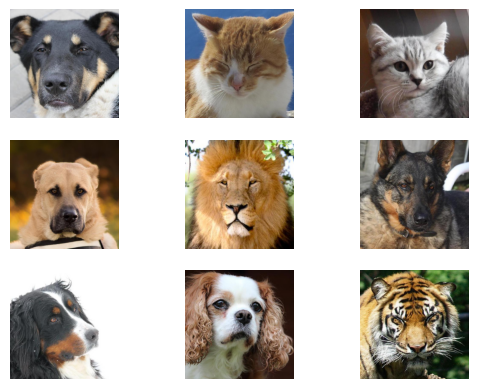

In [12]:

n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
    for col in range(n_cols):
      image = Image.open(data_df.sample(n = 1)['image_paths'].iloc[0]).convert("RGB")
      axarr[row, col].imshow(image)
      axarr[row, col].axis('off')

plt.show()

Now set the parameters

In [13]:
LR = 1e-4               # Learning Rate
BATCH_SIZE = 16         # Batch size
EPOCHS = 10             # Number of epochs

In [14]:

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

NOw define the layers of NN

In [15]:
class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1) # First Convolution layer
      self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1) # Second Convolution layer
      self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1) # Third Convolution layer
      self.pooling = nn.MaxPool2d(2,2) # The pooling layer, we will be using the same layer after each conv2d.
      self.relu = nn.ReLU() # ReLU Activation function

      self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
      self.linear = nn.Linear((128 * 16 * 16), 128) # Traditional Dense (Linear)
      self.output = nn.Linear(128, len(data_df['labels'].unique())) # Output Linear Layer


    def forward(self, x):
      x = self.conv1(x) # -> Outputs: (32, 128, 128)
      x = self.pooling(x)# -> Outputs: (32, 64, 64)
      x = self.relu(x)
      x = self.conv2(x) # -> Outputs: (64, 64, 64)
      x = self.pooling(x) # -> Outputs: (64, 32, 32)
      x = self.relu(x)
      x = self.conv3(x) # -> Outputs: (128, 32, 32)
      x = self.pooling(x) # -> Outputs: (128, 16, 16)
      x = self.relu(x)
      x = self.flatten(x)
      x = self.linear(x)
      x = self.output(x)

      return x

model = Net().to(device) # Create an instance of the model and move it to the GPU Device

In [17]:
!pip install torchsummary

In [18]:

from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

Define loss function and optimizer

In [19]:
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(model.parameters(), lr=LR) # Adam optimizer

In [20]:
# track our loss for plot after,

total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

# set loss for training
for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("="*25)

Epoch 1/10, Train Loss: 3.2296 Train Accuracy 81.4188
              Validation Loss: 0.5287 Validation Accuracy: 86.0331
Epoch 2/10, Train Loss: 1.4239 Train Accuracy 92.5427
              Validation Loss: 0.3355 Validation Accuracy: 91.7355
Epoch 3/10, Train Loss: 0.9134 Train Accuracy 95.3857
              Validation Loss: 0.2039 Validation Accuracy: 95.0826
Epoch 4/10, Train Loss: 0.6473 Train Accuracy 96.8205
              Validation Loss: 0.2116 Validation Accuracy: 95.1653
Epoch 5/10, Train Loss: 0.4824 Train Accuracy 97.6441
              Validation Loss: 0.1854 Validation Accuracy: 95.2066
Epoch 6/10, Train Loss: 0.367 Train Accuracy 98.1401
              Validation Loss: 0.1715 Validation Accuracy: 95.6612
Epoch 7/10, Train Loss: 0.2605 Train Accuracy 98.7335
              Validation Loss: 0.2613 Validation Accuracy: 94.5455
Epoch 8/10, Train Loss: 0.1638 Train Accuracy 99.1852
              Validation Loss: 0.2375 Validation Accuracy: 95.4132
Epoch 9/10, Train Loss: 0.1475 Tr

In [21]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")

Accuracy Score is: 95.494 and Loss is 0.026


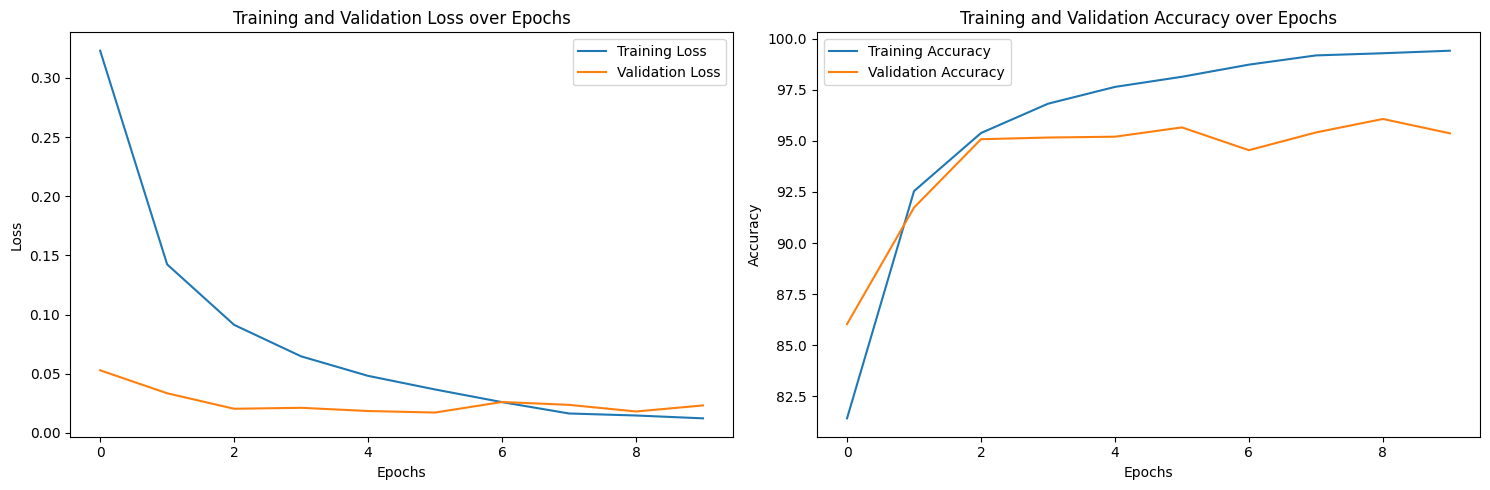

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

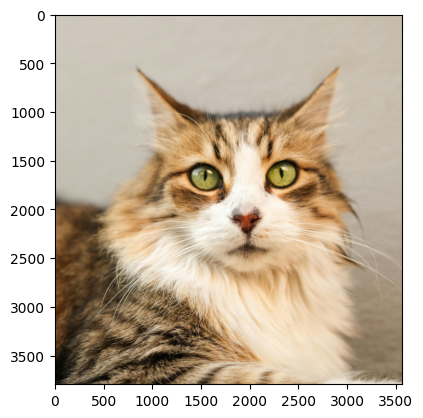


Prediction: 



array(['cat'], dtype=object)

In [26]:
# 1- read image
# 2- Transform using transform object
# 3- predict through the model
# 4- inverse transform by label encoder

def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

## Visualize the image
image = Image.open("./animal-faces/cute-cat-looking-at-camera.jpeg")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("./animal-faces/cute-cat-looking-at-camera.jpeg")